In [3]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [4]:
#Reading in data
df = pd.read_excel('/Users/arielthompson/Downloads/#Sample.xlsx')
df.head(25)

,month_year,part_number,product_category,Attribute_B,Attribute_C,Division,demand
0,2020-01-01,P10,A116,C10,B39,B,4
1,2020-02-01,P10,A116,C10,B39,B,8
2,2020-03-01,P10,A116,C10,B39,B,8
3,2020-04-01,P10,A116,C10,B39,B,15
4,2020-05-01,P10,A116,C10,B39,B,10
5,2020-06-01,P10,A116,C10,B39,B,13
6,2020-07-01,P10,A116,C10,B39,B,19
7,2020-09-01,P10,A116,C10,B39,B,6
8,2020-10-01,P10,A116,C10,B39,B,14
9,2020-11-01,P10,A116,C10,B39,B,15


In [5]:
#Converting 'month_year' to datetime format for time series analyst
df['month_year'] = pd.to_datetime(df['month_year'])
df.set_index('month_year', inplace=True)
demand = df['demand'].astype(float).values.reshape(-1, 1)

#Scaling data to a range of [0,1] (helping model train better)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(demand)

In [6]:
#Splitting data into training and testing sets (matching LSTM model input shape)
window_size = 12 #in the last year
X = []
y= []
target_dates = df.index[window_size:]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, target_dates, test_size=0.2, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [7]:
#Building model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
#Traing / testing the model; Finding RSME for performance
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rsme = np.sqrt(np.mean((y_test - predictions) ** 2))
print(f'RSME: {rsme:.2f}')

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step - loss: 0.0231 - val_loss: 0.2601
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0170 - val_loss: 0.2153
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0164 - val_loss: 0.1955
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0182 - val_loss: 0.1970
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0168 - val_loss: 0.2057
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0158 - val_loss: 0.2153
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0145 - val_loss: 0.2218
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0150 - val_loss: 0.2247
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0151 - val_loss: 0.2237
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0153 - val_loss: 0.2194
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0154 - val_loss: 0.2130
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0152 - val_l

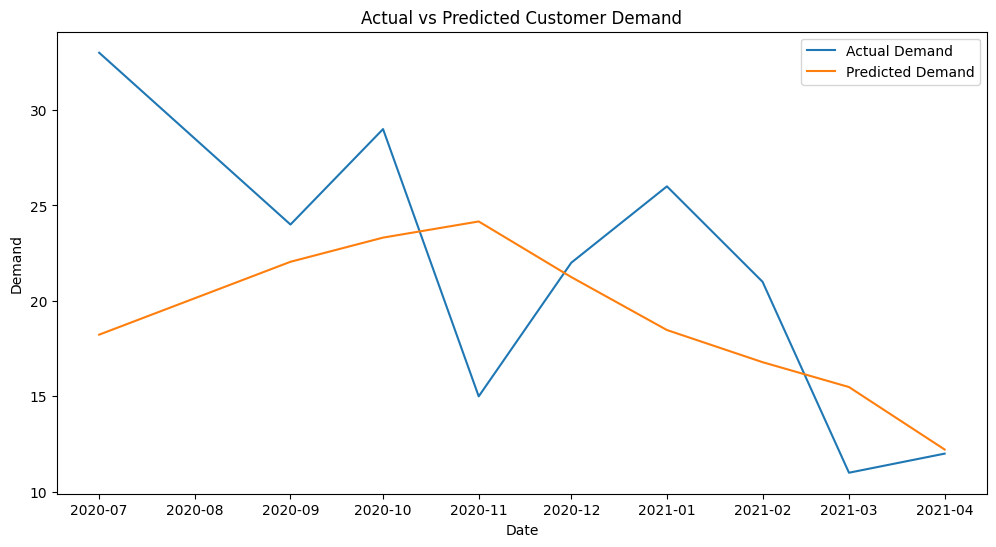

In [9]:
#Visualizing model performance
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Demand')
plt.plot(dates_test, predictions, label='Predicted Demand')
plt.title('Actual vs Predicted Customer Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()